In [25]:
%load_ext autoreload
%autoreload 2


In [2]:
from simple_transformer import Transformer
from dataset import StreaksDataset
import datasets.datasets as datasets
import torch
import utils


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/dofri/miniconda3/envs/new_env/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/dofri/miniconda3/envs/new_env/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/dofri/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/dofri/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [116]:

model = Transformer()
model.eval()
batch_size = 8
inputs = torch.randn(batch_size, 512, 32)
numeric_features = torch.rand(batch_size,5)
mask = torch.ones(batch_size, 512, dtype=torch.bool)
mask[:, 256:] = 0
outputs = model(inputs, numeric_features, mask)
print(outputs.shape)
print(outputs)

torch.Size([8, 1])
tensor([[ 0.2081],
        [ 0.0524],
        [ 0.0327],
        [-0.0637],
        [-0.2525],
        [-0.0735],
        [ 0.1891],
        [ 0.2999]], grad_fn=<AddmmBackward0>)


In [117]:

# Print the number of parameters
num_params = sum(p.numel() for p in model.parameters())

In [118]:
print(num_params)

125633


In [17]:

# load all images
# images_train = 
# 
# train_dataset = StreaksDataset(


AttributeError: module 'datasets' has no attribute 'split_data'

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
train=0.8
val=0.1
test=0.1
seed=1104

# Load the data
good_data = pd.read_csv(os.path.join(utils.get_project_root(), 'good_data.csv'))
numerical_data_df = pd.read_csv(os.path.join(utils.get_project_root(), 'datasets/auxiliary_data.csv'))
targets_df = pd.read_csv(os.path.join(utils.get_project_root(), 'datasets/targets.csv'))
# Split data by filenames
file_names = good_data['file_name'].unique()
file_names_temp, file_names_test = train_test_split(file_names, train_size=train+val, random_state=seed)
file_names_train, file_names_val = train_test_split(file_names_temp, train_size=train/(train+val), random_state=seed + 1)
 
train_data = good_data[good_data['file_name'].isin(file_names_train)]
val_data = good_data[good_data['file_name'].isin(file_names_val)]
test_data = good_data[good_data['file_name'].isin(file_names_test)]

def get_data(data):
    images = [
        torch.tensor(np.load(utils.get_strip_file_path(row)), dtype=torch.float) for (_, row) in data.iterrows()
    ]
    numeric = torch.tensor(
        pd.merge(data, numerical_data_df, on='file_name')[numerical_data_df.columns].drop(columns=['file_name']).to_numpy()
    )
    targets = torch.tensor(
        pd.merge(data.drop(columns=['ang_vel[deg/s]']), targets_df, on=['file_name', 'extension', 'ID'])['ang_vel[deg/s]'].to_numpy()
    )
    return images, numeric, targets

print(get_data(train_data)[0][0].shape)

train_dataset = StreaksDataset(*get_data(train_data))

val_dataset = StreaksDataset(*get_data(val_data), 
                             images_mean=train_dataset.images_mean,
                             images_std=train_dataset.images_std,
                             numeric_features_mean=train_dataset.numeric_features_mean,
                             numeric_features_std=train_dataset.numeric_features_std,
                             targets_mean=train_dataset.targets_mean,
                             targets_std=train_dataset.targets_std)
test_dataset = StreaksDataset( *get_data(test_data),
                               images_mean=train_dataset.images_mean,
                               images_std=train_dataset.images_std,
                               numeric_features_mean=train_dataset.numeric_features_mean,
                               numeric_features_std=train_dataset.numeric_features_std,
                               targets_mean=train_dataset.targets_mean,
                               targets_std=train_dataset.targets_std)
train_dataset.__getitem__(1)[0].shape




In [3]:
from train import train

train()


Epoch 1/10 - Training:   0%|          | 0/59 [00:00<?, ?it/s]

Numeric features shape:  torch.Size([16, 7])


KeyboardInterrupt: 

In [19]:
from transformer_artifical_data import artificial_transformer

import torch

model = artificial_transformer.Transformer()


data = torch.rand(8,200,32)
targets = torch.randn(8,1)
mask = torch.zeros(8, 200, dtype=torch.bool)

model.forward(data, mask)



tensor([[0.0902],
        [0.1057],
        [0.1115],
        [0.0832],
        [0.0351],
        [0.0462],
        [0.1017],
        [0.1351]], grad_fn=<AddmmBackward0>)

Results saved to /home/dofri/epfl/semester_project/src/analysis/results/test1.csv
Correlation between True Frequency and MSE: 0.9406, p-value: 5.9607e-08
Correlation between Width and MSE: 0.1717, p-value: 5.2484e-01
Mean squared error: 5.6633, Mean error: -1.9869, Mean absolute error: 2.0663


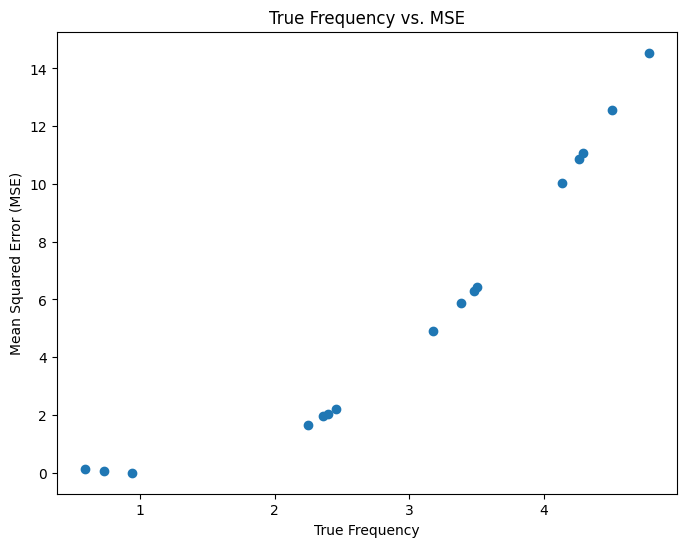

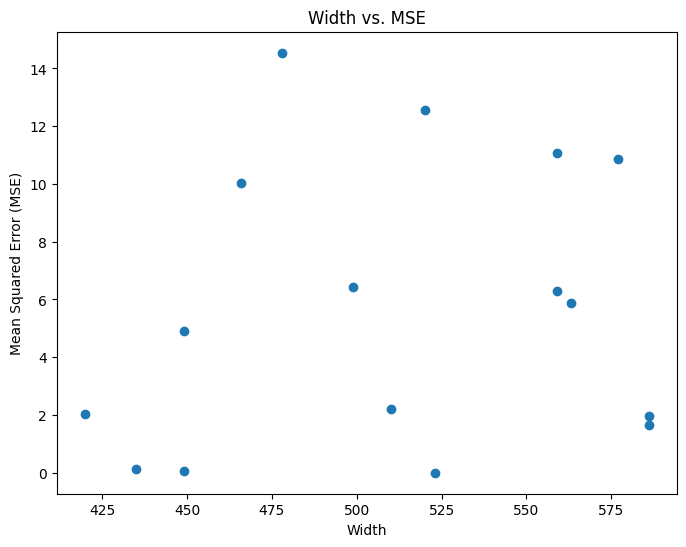

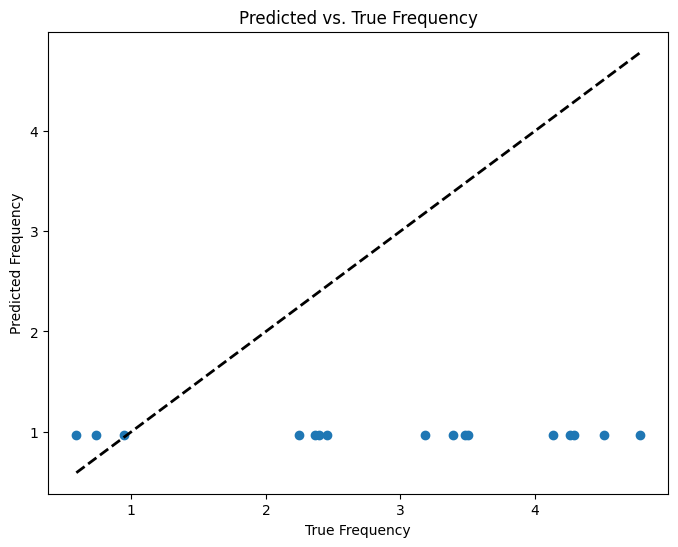

In [32]:
from transformer_artifical_data import artificial_dataset
from src.analysis.artificial_model_analysis import evaluate_model
from src.analysis.artificial_model_analysis import analyze_results


# Dummy test dataset
datasets, dfs = artificial_dataset.split_data_into_datasets(train=.1, val=.1, test=.8, no_samples=20)
model = artificial_transformer.Transformer()

eval_df = evaluate_model(model, datasets['test'], dfs['test'], save=True, file_name="test1", desc="This is just a test to test the model")
analyze_results(eval_df)




In [7]:
# import zipfile
# import os
# from src import utils
# zip_path = os.path.join(utils.get_project_root(), 'src','datasets','artificial_strips.zip')
# extract_to = os.path.join(utils.get_project_root(), 'src', 'datasets')
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)
#     print(f"Unzipped {zip_path} to {extract_to}")

Unzipped /home/dofri/epfl/semester_project/src/datasets/artificial_strips.zip to /home/dofri/epfl/semester_project/src/datasets
